<a href="https://colab.research.google.com/github/ohilikeit/KERC-2022_korean-NLP/blob/main/klue_roberta_large.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install transformers
! pip install datasets transformers[sentencepiece]
! pip install accelerate
! pip install torchmetrics
! pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

In [ ]:
# pororo 설치 
!pip install --upgrade pip
!git clone https://github.com/kakaobrain/pororo.git
ls
cd pororo
!pip install -e .

# 1. 데이터 로드 및 전처리

In [14]:
import os, sys
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from transformers import (AutoModelForSequenceClassification, AutoTokenizer, AutoModel, AdamW, AutoConfig, get_cosine_with_hard_restarts_schedule_with_warmup, get_cosine_schedule_with_warmup)
import torch.nn.functional as F
from torchmetrics import F1Score
from datasets import load_metric
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')
import gc
import re
import torch
import torch.nn as nn
from accelerate import Accelerator, notebook_launcher
os.chdir('/content/drive/MyDrive/ML_projects/Korean')
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

# 제공 데이터 
train_data = pd.read_csv('./train_data.tsv', delimiter='\t').fillna('').drop(['person', 'scene'], axis=1)
public_test_data = pd.read_csv('./public_test_data.tsv', delimiter='\t').fillna('').drop(['person', 'scene'], axis=1)
private_test_data = pd.read_csv('./private_test_data.tsv', delimiter='\t').fillna('').drop(['person', 'scene'], axis=1)
public_test_data['label'] = 'none'
private_test_data['label'] = 'none'
test_data = pd.concat([public_test_data, private_test_data]).reset_index(drop=True)
train_labels = pd.read_csv('./train_labels.csv')

train_data = pd.merge(train_data, train_labels, on = 'sentence_id')

In [16]:
train_data

,sentence_id,sentence,context,label
0,1,야! 전화 받아. 아무리 바빠도 내전화는 받아야 되는거 아냐? 약속 하나도 못지키는...,,dysphoria
1,2,우리 아무래도 안되겠다. 이게 최선인거 같애. 평생 잊지 않을게. 행복하길 바란다.,"포기한듯 탁 일어서는데, 띵동 문자. 후다닥 보는 어영. 기막혀 읽어보는",dysphoria
2,3,"김경사님, 아직 안가셨어요? 시간 다됐을텐데.",초조하게 시계보면서 왔다갔다 서성이는 김순경. 순찰차(경차)와서 멈추고 내리는 지구대,neutral
3,4,근무중인데 어딜가?,초조하게 시계보면서 왔다갔다 서성이는 김순경. 순찰차(경차)와서 멈추고 내리는 지구대,dysphoria
4,5,다녀오세요. 이런날은 무조건 가서 축하해주셔야죠. 이순경이 대신 근무선다고 나온대요.,초조하게 시계보면서 왔다갔다 서성이는 김순경. 순찰차(경차)와서 멈추고 내리는 지구대,euphoria
...,...,...,...,...
7334,12285,종남이 맛있는것도 사주고 잘 챙겨줘.,,euphoria
7335,12286,걱정마라. 먹어도 같이 먹고 굶어도 같이 굶는다.,,euphoria
7336,12287,아빠. 우리 저거 타.,,euphoria
7337,12288,"나 못타는데. 한번도 안타봤어. 툭하면 차멀미까지 하는데, 봐라, 너도 내몸땡이에 ...",,euphoria


In [4]:
train_data['label'].value_counts()

dysphoria    4526
euphoria     1967
neutral       846
Name: label, dtype: int64

## 1) 데이터 증강 - pororo back translation

In [ ]:
# back translation 데이터 증강 
from pororo import Pororo
mt = Pororo(task="translation", lang="multi")

def translate(text, lang):
    txt = mt(text, src='ko', tgt=lang)
    res = mt(txt, src=lang, tgt='ko')
    return res

pororo_en = train_data.copy()
pororo_ja = train_data.copy()

# 한국어 -> 영어 -> 한국어
pororo_en['sentence'] = pororo_en['sentence'].progress_apply(lambda x: translate(x, 'en'))
pororo_en['context'] = pororo_en['context'].progress_apply(lambda x: translate(x, 'en'))

# 한국어 -> 일본어 -> 한국어
pororo_ja['sentence'] = pororo_ja['sentence'].progress_apply(lambda x: translate(x, 'ja'))
pororo_ja['context'] = pororo_ja['context'].progress_apply(lambda x: translate(x, 'ja'))

# 증강한 데이터와 원래 데이터 통합 
train_data = pd.concat([train_data, pororo_en, pororo_ja])
train_labels = train_data[['sentence_id','label']]

In [2]:
# # 저장
# pororo_en.to_csv('./pororo_en.csv', encoding='cp949', index=False)
# with open('./pororo_ja.pickle', 'wb') as f:
#     pickle.dump(pororo_ja, f, pickle.HIGHEST_PROTOCOL)
# # 불러오기 
# pororo_en = pd.read_csv('./pororo_en.csv', encoding='cp949').fillna('')
# with open('./pororo_ja.pickle', 'rb') as f:
#     pororo_ja = pickle.load(f) 
# pororo_ja.loc[pororo_ja['context'] == '…하다', 'context'] = ""

# 2. 학습

In [5]:
checkpoint = 'klue/roberta-large' 
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

params = {
    'batch_size' : 16,
    'max_len' : 64,
    'epoch' : 3,
    'learning_rate' :2e-5,
    'weight_decay' : 0.01,
    'warmup_rate' : 0.1
}

class RoBERTaDataset(torch.utils.data.Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __getitem__(self, idx):  # 객체 슬라이싱 설정 
        item = {key: value[idx].clone().detach() for key, value in self.data.items()}
        item['labels'] = torch.tensor(self.label[idx])
        
        return item

    def __len__(self):
        return len(self.label)

def changer(label, state=True):
    res = []

    if state:
        labels = {"dysphoria": 0, "euphoria": 1, "neutral": 2, "none": 3}
        for i in label:
            res.append(labels[i])

    elif state == False:
        labels = {0 : "dysphoria", 1 : "euphoria", 2 : "neutral"}
        for i, v in enumerate(label):
            res.append([i,labels[v]])

    return res

F1 = F1Score(num_classes=3, average = 'micro')

class FocalLoss(nn.CrossEntropyLoss):
    ''' Focal loss for classification tasks on imbalanced datasets '''

    def __init__(self, gamma=4, alpha=None, ignore_index=0, reduction='none'):
        super().__init__(weight=alpha, ignore_index=ignore_index, reduction='none')
        self.reduction = reduction
        self.gamma = gamma

    def forward(self, input_, target):
        cross_entropy = super().forward(input_, target)
        # Temporarily mask out ignore index to '0' for valid gather-indices input.
        # This won't contribute final loss as the cross_entropy contribution
        # for these would be zero.
        target = target * (target != self.ignore_index).long()
        input_prob = torch.gather(F.softmax(input_, 1), 1, target.unsqueeze(1))
        loss = torch.pow(1 - input_prob, self.gamma) * cross_entropy
        return torch.mean(loss)

Loss = FocalLoss()

In [6]:
def RoBERTa_trainer():
    accelerator = Accelerator()
    
    config = AutoConfig.from_pretrained(checkpoint)
    config.num_labels = 3
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)
    optimizer = AdamW(model.parameters(), lr= params['learning_rate'], weight_decay= params['weight_decay']) 

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=params['batch_size'], sampler=train_subsampler)
    eval_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=params['batch_size'], sampler=test_subsampler)
    
    model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(model, optimizer, train_dataloader, eval_dataloader)

    total_epoch = params['epoch']
    num_training_steps = total_epoch * len(train_dataloader)
    progress_bar = tqdm(range(num_training_steps))
    lr_scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=int(params['warmup_rate'] * num_training_steps),
        num_training_steps=num_training_steps,
    )

    for epoch in range(total_epoch):
        seed_everything(epoch)
        train_f1 = 0.0
        test_f1 = 0.0

        model.train()
        for batch_id, batch in enumerate(train_dataloader):
            res = model(batch['input_ids'], batch['attention_mask'], batch['token_type_ids'])

            # # focal+smoothing
            # logits = res.get('logits')
            # criteria = FocalLossWithSmoothing(3)
            # loss = criteria(logits.view(-1, 3),  batch['labels'].view(-1))

            # loss = F.cross_entropy(res[0], batch['labels'])
            
            loss = Loss(res[0], batch['labels']) 
            accelerator.backward(loss)

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

            train_f1 += F1(res.logits.cpu(), batch['labels'].data.cpu())
        print("epoch {} train_f1 {}".format(epoch+1, train_f1 / (batch_id+1)))

        model.eval()
        for batch_id, batch in enumerate(eval_dataloader):
            with torch.no_grad():
                res = model(batch['input_ids'], batch['attention_mask'], batch['token_type_ids'])

            test_f1 += F1(res.logits.cpu(), batch['labels'].data.cpu())
        print("epoch {} test_f1 {}".format(epoch+1, test_f1 / (batch_id+1)))

        gc.collect()

    accelerator.wait_for_everyone()
    final_model = accelerator.unwrap_model(model)
    final_model.save_pretrained('./experiments/experiment' + str(fold), save_function = accelerator.save)

In [7]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tokenized_train = tokenizer(
    list(train_data['sentence']),
    list(train_data['context']),
    return_tensors="pt",
    max_length=params['max_len'],
    padding=True,
    truncation=True,
    add_special_tokens=True
    )

for fold, (train_ids, test_ids) in enumerate(kfold.split(train_data, train_labels['label'])):
    print('--------------------------------')
    print(f'FOLD {fold}')
    print('--------------------------------')

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    train_label = changer(train_labels['label'])
    train_dataset = RoBERTaDataset(tokenized_train, train_label)

    notebook_launcher(RoBERTa_trainer)

--------------------------------
FOLD 0
--------------------------------
Launching a training on 8 TPU cores.


Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classif

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

epoch 1 train_f1 0.5928441882133484
epoch 1 train_f1 0.58152174949646epoch 1 train_f1 0.6082427501678467epoch 1 train_f1 0.5955616235733032epoch 1 train_f1 0.5955616235733032epoch 1 train_f1 0.5738224387168884epoch 1 train_f1 0.5797101259231567
epoch 1 train_f1 0.5711050629615784





epoch 1 test_f1 0.6928571462631226
epoch 1 test_f1 0.6642857193946838epoch 1 test_f1 0.7160714268684387epoch 1 test_f1 0.7017857432365417


epoch 1 test_f1 0.6910714507102966epoch 1 test_f1 0.7142857313156128

epoch 1 test_f1 0.6964285969734192
epoch 1 test_f1 0.6803571581840515
epoch 2 train_f1 0.751358687877655
epoch 2 train_f1 0.7631340622901917epoch 2 train_f1 0.7558876872062683epoch 2 train_f1 0.74048912525177epoch 2 train_f1 0.7481883764266968
epoch 2 train_f1 0.7477355003356934
epoch 2 train_f1 0.7472826242446899
epoch 2 train_f1 0.741847813129425



epoch 2 test_f1 0.7767857313156128
epoch 2 test_f1 0.7803571224212646
epoch 2 test_f1 0.7428571581840515
epoch 2 test_f1 0.7589285969734192
epoch 2 te

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classif

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

epoch 1 train_f1 0.554347813129425epoch 1 train_f1 0.59375epoch 1 train_f1 0.5661231875419617epoch 1 train_f1 0.5760869383811951



epoch 1 train_f1 0.5679348111152649epoch 1 train_f1 0.5892210006713867epoch 1 train_f1 0.5837862491607666epoch 1 train_f1 0.5679348111152649



epoch 1 test_f1 0.6982142925262451
epoch 1 test_f1 0.7196428775787354
epoch 1 test_f1 0.6839285492897034
epoch 1 test_f1 0.7357142567634583
epoch 1 test_f1 0.6857143044471741
epoch 1 test_f1 0.699999988079071
epoch 1 test_f1 0.6964285969734192
epoch 1 test_f1 0.699999988079071
epoch 2 train_f1 0.7509058117866516epoch 2 train_f1 0.7305253744125366epoch 2 train_f1 0.7427536249160767

epoch 2 train_f1 0.7509058117866516epoch 2 train_f1 0.7463768124580383
epoch 2 train_f1 0.7549818754196167epoch 2 train_f1 0.7531703114509583epoch 2 train_f1 0.7490941882133484




epoch 2 test_f1 0.7535714507102966
epoch 2 test_f1 0.737500011920929
epoch 2 test_f1 0.7696428298950195
epoch 2 test_f1 0.7678571343421936
epoch 2 test_f1 0.7

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classif

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

epoch 1 train_f1 0.5932971239089966
epoch 1 train_f1 0.5896739363670349epoch 1 train_f1 0.5738224387168884epoch 1 train_f1 0.5670289993286133epoch 1 train_f1 0.58423912525177epoch 1 train_f1 0.5914855003356934epoch 1 train_f1 0.582880437374115


epoch 1 train_f1 0.5634058117866516



epoch 1 test_f1 0.699999988079071
epoch 1 test_f1 0.7142857313156128epoch 1 test_f1 0.7089285850524902

epoch 1 test_f1 0.7124999761581421
epoch 1 test_f1 0.7160714268684387
epoch 1 test_f1 0.7250000238418579
epoch 1 test_f1 0.7321428656578064epoch 1 test_f1 0.6642857193946838

epoch 2 train_f1 0.741847813129425epoch 2 train_f1 0.7531703114509583epoch 2 train_f1 0.741847813129425epoch 2 train_f1 0.7436594367027283epoch 2 train_f1 0.7504528760910034epoch 2 train_f1 0.7359601259231567


epoch 2 train_f1 0.7527173757553101epoch 2 train_f1 0.7350543737411499




epoch 2 test_f1 0.7107142806053162epoch 2 test_f1 0.7714285850524902

epoch 2 test_f1 0.7696428298950195
epoch 2 test_f1 0.7410714030265808
epoch 2 te

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classif

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

epoch 1 train_f1 0.5738224387168884
epoch 1 train_f1 0.5824275612831116epoch 1 train_f1 0.5797101259231567epoch 1 train_f1 0.5824275612831116epoch 1 train_f1 0.582880437374115epoch 1 train_f1 0.55298912525177epoch 1 train_f1 0.5692934989929199
epoch 1 train_f1 0.582880437374115





epoch 1 test_f1 0.6732142567634583
epoch 1 test_f1 0.637499988079071
epoch 1 test_f1 0.6499999761581421
epoch 1 test_f1 0.6696428656578064
epoch 1 test_f1 0.6642857193946838
epoch 1 test_f1 0.6303571462631226
epoch 1 test_f1 0.6785714030265808
epoch 1 test_f1 0.6785714030265808
epoch 2 train_f1 0.75epoch 2 train_f1 0.7554348111152649
epoch 2 train_f1 0.7518116235733032epoch 2 train_f1 0.7495471239089966epoch 2 train_f1 0.7341485619544983epoch 2 train_f1 0.7373188138008118
epoch 2 train_f1 0.7463768124580383epoch 2 train_f1 0.75





epoch 2 test_f1 0.7250000238418579
epoch 2 test_f1 0.7071428298950195epoch 2 test_f1 0.7250000238418579

epoch 2 test_f1 0.6821428537368774
epoch 2 test_f1 0.7214285731315613
ep

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classif

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/414 [00:00<?, ?it/s]

epoch 1 train_f1 0.5778985619544983
epoch 1 train_f1 0.5679348111152649epoch 1 train_f1 0.5837862491607666epoch 1 train_f1 0.5670289993286133epoch 1 train_f1 0.5724637508392334epoch 1 train_f1 0.58152174949646epoch 1 train_f1 0.5874094367027283epoch 1 train_f1 0.5774456262588501






epoch 1 test_f1 0.7517856955528259
epoch 1 test_f1 0.7482143044471741
epoch 1 test_f1 0.7321428656578064
epoch 1 test_f1 0.7553571462631226
epoch 1 test_f1 0.7285714149475098
epoch 1 test_f1 0.7142857313156128
epoch 1 test_f1 0.7071428298950195
epoch 1 test_f1 0.7410714030265808
epoch 2 train_f1 0.74048912525177
epoch 2 train_f1 0.7237318754196167epoch 2 train_f1 0.7278079986572266epoch 2 train_f1 0.73097825050354epoch 2 train_f1 0.7490941882133484

epoch 2 train_f1 0.7350543737411499epoch 2 train_f1 0.7436594367027283

epoch 2 train_f1 0.7495471239089966


epoch 2 test_f1 0.6803571581840515
epoch 2 test_f1 0.7232142686843872
epoch 2 test_f1 0.6964285969734192
epoch 2 test_f1 0.7250000238418579
epoch 2 te

# 3. 추론 및 voting

## 추론

In [29]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
test_label = changer(test_data['label'].values)
df = test_data.copy()
tokenized_test = tokenizer(
    list(test_data['sentence']),
    list(test_data['context']),
    return_tensors="pt",
    max_length=params['max_len'],
    padding=True,
    truncation=True,
    add_special_tokens=True
)

test_dataset = RoBERTaDataset(tokenized_test, test_label)
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

for fold in range(5):
    config = AutoConfig.from_pretrained(checkpoint)
    config.num_labels = 3
    model = AutoModelForSequenceClassification.from_pretrained('./experiments/experiment' + str(fold), num_labels=3) 
    model.resize_token_embeddings(tokenizer.vocab_size)

    accelerator = Accelerator()
    model = accelerator.unwrap_model(model)
    output_pred = []
    model, dataloader= accelerator.prepare(model, dataloader)
    model.eval()
    for i, data in enumerate(tqdm(dataloader)):
        with torch.no_grad():
            outputs = model(input_ids=data['input_ids'], attention_mask=data['attention_mask'])
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        result = np.argmax(logits, axis=-1)
        output_pred.append(result)
        
    pred_answer = np.concatenate(output_pred).tolist()
    answer = changer(pred_answer, state=False)
    df_label = pd.DataFrame(answer, columns=['index', 'label'])

    df[f'label{fold}'] = df_label['label']

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

  0%|          | 0/310 [00:00<?, ?it/s]

## hard voting

In [ ]:
# 5 fold 결과물 종합 
def label_count(df):
  num_dysphoria = 0
  num_euphoria = 0
  num_neutral = 0
  cols = ['label0', 'label1', 'label2', 'label3', 'label4']
  for col in cols:
    if df[col] == 'dysphoria':
      num_dysphoria += 1
    if df[col] == 'euphoria':
      num_euphoria += 1
    if df[col] == 'neutral':
      num_neutral += 1

  return [num_dysphoria, num_euphoria, num_neutral]
cnt = df.apply(label_count, axis=1)
df['cnt'] = cnt

# 각각 분리하기 
df['dysphoria'] = 0
df['euphoria'] = 0
df['neutral'] = 0
for i in range(len(df)):
    df.loc[i, 'dysphoria'] = df.loc[i, 'cnt'][0]
    df.loc[i, 'euphoria'] = df.loc[i, 'cnt'][1]
    df.loc[i, 'neutral'] = df.loc[i, 'cnt'][2]

# hard voting
def voting(df):
  cols = ['dysphoria', 'euphoria', 'neutral']
  for col in cols:
    if df[col] > 2:
      return col
  return 'dysphoria'

df['label'] = df.apply(voting, axis=1)

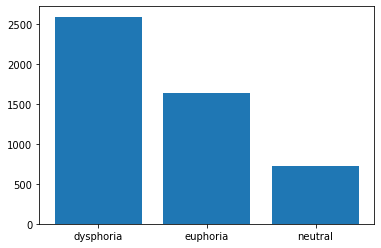

In [44]:
num_dysphoria = df['label'].value_counts()['dysphoria']
num_euphoria = df['label'].value_counts()['euphoria']
num_neutral = df['label'].value_counts()['neutral']

counts = [num_dysphoria, num_euphoria, num_neutral]
labels = ['dysphoria', 'euphoria', 'neutral']
plt.bar(labels, counts)
plt.show()  

In [45]:
df['label'].value_counts(normalize=True)

dysphoria    0.523030
euphoria     0.330909
neutral      0.146061
Name: label, dtype: float64

In [ ]:
final = df[['sentence_id', 'label']]
final.columns = ['Id', 'Predicted']
final.to_csv('./submission_윤지환.csv', index=False)

# 4. 실패작들

In [ ]:
# # AI Hub 데이터 - 단발성 
# kor_df_1 = pd.read_excel('./한국어_단발성_대화_데이터셋.xlsx')
# kor_df_1.drop(kor_df_1.columns[2:7], axis=1, inplace=True)
# kor_df_1.columns = ['sentence', 'label']

# kor_df_1 = kor_df_1[kor_df_1['label'].isin(['슬픔', '중립', '행복'])]
# kor_df_1.loc[kor_df_1['label'] == '슬픔', 'label'] = 'dysphoria'
# kor_df_1.loc[kor_df_1['label'] == '중립', 'label'] = 'neutral'
# kor_df_1.loc[kor_df_1['label'] == '행복', 'label'] = 'euphoria'

# # AI Hub 데이터 - 연속적
# kor_df_2 = pd.read_excel('./한국어_연속적_대화_데이터셋.xlsx')
# kor_df_2 = kor_df_2[['Unnamed: 1', 'Unnamed: 2']][1:]
# kor_df_2.columns = ['sentence', 'label']

# kor_df_2 = kor_df_2[kor_df_2['label'].isin(['슬픔', '중립', '행복'])]
# kor_df_2.loc[kor_df_2['label'] == '슬픔', 'label'] = 'dysphoria'
# kor_df_2.loc[kor_df_2['label'] == '중립', 'label'] = 'neutral'
# kor_df_2.loc[kor_df_2['label'] == '행복', 'label'] = 'euphoria'

# # 데이터 통합 
# train_data = pd.concat([train_data, kor_df_1, kor_df_2]).fillna('')
# train_labels = train_data[['sentence_id', 'label']]

# class FocalLossWithSmoothing(nn.Module):
#     def __init__(
#             self,
#             num_classes: int = int,
#             gamma: int = 5,
#             lb_smooth: float = 0.1,
#             size_average: bool = True,
#             ignore_index: int = None,
#             alpha: float = None):
#         """
#         :param gamma:
#         :param lb_smooth:
#         :param ignore_index:
#         :param size_average:
#         :param alpha:
#         """
#         super(FocalLossWithSmoothing, self).__init__()
#         self._num_classes = num_classes
#         self._gamma = gamma
#         self._lb_smooth = lb_smooth
#         self._size_average = size_average
#         self._ignore_index = ignore_index
#         self._log_softmax = nn.LogSoftmax(dim=1)
#         self._alpha = alpha

#         if self._num_classes <= 1:
#             raise ValueError('The number of classes must be 2 or higher')
#         if self._gamma < 0:
#             raise ValueError('Gamma must be 0 or higher')
#         if self._alpha is not None:
#             if self._alpha <= 0 or self._alpha >= 1:
#                 raise ValueError('Alpha must be 0 <= alpha <= 1')

#     def forward(self, logits, label):
#         """
#         :param logits: (batch_size, class, height, width)
#         :param label:
#         :return:
#         """
#         logits = logits.float()
#         difficulty_level = self._estimate_difficulty_level(logits, label)

#         with torch.no_grad():
#             label = label.clone().detach()
#             if self._ignore_index is not None:
#                 ignore = label.eq(self._ignore_index)
#                 label[ignore] = 0
#             lb_pos, lb_neg = 1. - self._lb_smooth, self._lb_smooth / (self._num_classes - 1)
#             lb_one_hot = torch.empty_like(logits).fill_(
#                 lb_neg).scatter_(1, label.unsqueeze(1), lb_pos).detach()
#         logs = self._log_softmax(logits)
#         loss = -torch.sum(difficulty_level * logs * lb_one_hot, dim=1)
#         if self._ignore_index is not None:
#             loss[ignore] = 0
#         return loss.mean()

#     def _estimate_difficulty_level(self, logits, label):
#         """
#         :param logits:
#         :param label:
#         :return:
#         """
#         one_hot_key = torch.nn.functional.one_hot(label, num_classes=self._num_classes)
#         if len(one_hot_key.shape) == 4:
#             one_hot_key = one_hot_key.permute(0, 3, 1, 2)
#         if one_hot_key.device != logits.device:
#             one_hot_key = one_hot_key.to(logits.device)
#         pt = one_hot_key * F.softmax(logits)
#         difficulty_level = torch.pow(1 - pt, self._gamma)
#         return difficulty_level
# class LabelSmoothingLoss(nn.Module):
#     def __init__(self, classes, smoothing, dim=-1, weight = None):
#         """if smoothing == 0, it's one-hot method
#            if 0 < smoothing < 1, it's smooth method
#         """
#         super(LabelSmoothingLoss, self).__init__()
#         self.confidence = 1.0 - smoothing
#         self.smoothing = smoothing
#         self.weight = weight
#         self.cls = classes
#         self.dim = dim

#     def forward(self, pred, target):
#         assert 0 <= self.smoothing < 1
#         pred = pred.log_softmax(dim=self.dim)

#         if self.weight is not None:
#             pred = pred * self.weight.unsqueeze(0)   

#         with torch.no_grad():
#             true_dist = torch.zeros_like(pred)
#             true_dist.fill_(self.smoothing / (self.cls - 1))
#             true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
#         return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))
# Loss = LabelSmoothingLoss(classes = 3, smoothing = 0.1)


# train_data = pd.read_csv('./train_data.tsv', delimiter='\t').fillna(' ').drop(['person', 'scene'], axis=1)
# public_test_data = pd.read_csv('./public_test_data.tsv', delimiter='\t').fillna(' ').drop(['person', 'scene'], axis=1)
# public_test_data['label'] = 'none'
# train_labels = pd.read_csv('./train_labels.csv')
# print(train_labels['label'].value_counts(normalize=True))
# print('-----------------------------------------------------')

# lst_1 = []
# lst_2 = []
# lst_3 = []
# for i in range(len(train_data)):
#     if (len(train_data.sentence.iloc[i]) < 5) | (len(train_data.context.iloc[i]) < 5):
#         continue
#     else:
#         lst_1.append(train_data.sentence_id.iloc[i])
#         lst_2.append(EDA(train_data.sentence.iloc[i]))
#         lst_3.append(EDA(train_data.context.iloc[i]))

# a = pd.Series(np.repeat(lst_1, 5))
# b = pd.Series(np.array(lst_2).flatten())
# c = pd.Series(np.array(lst_3).flatten())

# df = pd.concat([a,b,c], axis=1)
# df.columns = ['sentence_id', 'sentence', 'context']

# train_data = pd.merge(pd.concat([train_data, df]), train_labels, how='left', on='sentence_id')
# train_data.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=True)

# train_labels = train_data[['sentence_id', 'label']]
# print(train_labels['label'].value_counts(normalize=True))